This Jupyternotebook implements diffusive routing module that is bulit by solving the finite difference equation by Crank-Nicolson Hermite Interpolation method derived by Ehab A Meselhe, Professor, Department of River-Coastal Science and Engineering, Tulane University. 

The listed fortran source codes are the main routing engine that route water across NHD domains and this Python routing framework read NHD domains to feed inputs to the engine and take routed results back to this framework for managing outputs. The fortran codes were mainly developed by Md Nazmul Azim Beg,  Postdoctoral Fellow, Tulane River and Coastal Center, Department of River-Coastal Science and Engineering, Tulane University and modified by Dong Ha Kim, NOAA's Office of Water Prediction, National Water Center to transform them to Python extension module, which is then mounted on this routing framework. This routing framework was originally developed by James Halgren, NOAA's Office of Water Prediction, National Water Center. 

Fortran souce codes:
    Path: ../src/fortran_routing/diffCNHI_pylink
    Fortran files:  nrtype.f90
                    var_module.f90
                    subtools.f90
                    readXsection.f90
                    uniformflowLT.f90
                    calculateDT.f90
                    ef_q_y_calc.f90
                    
.py files:
    Path: ../src/python_routing
    files:  routelink_adjustment.py
            set_boundarydata.py
            waterdepth_lookuptable.py
            xsec_lookuptable.py
            
                    
The tested NHD domain is a simple Y-channel with a single junction (it is designed to expand to multiple junctions):

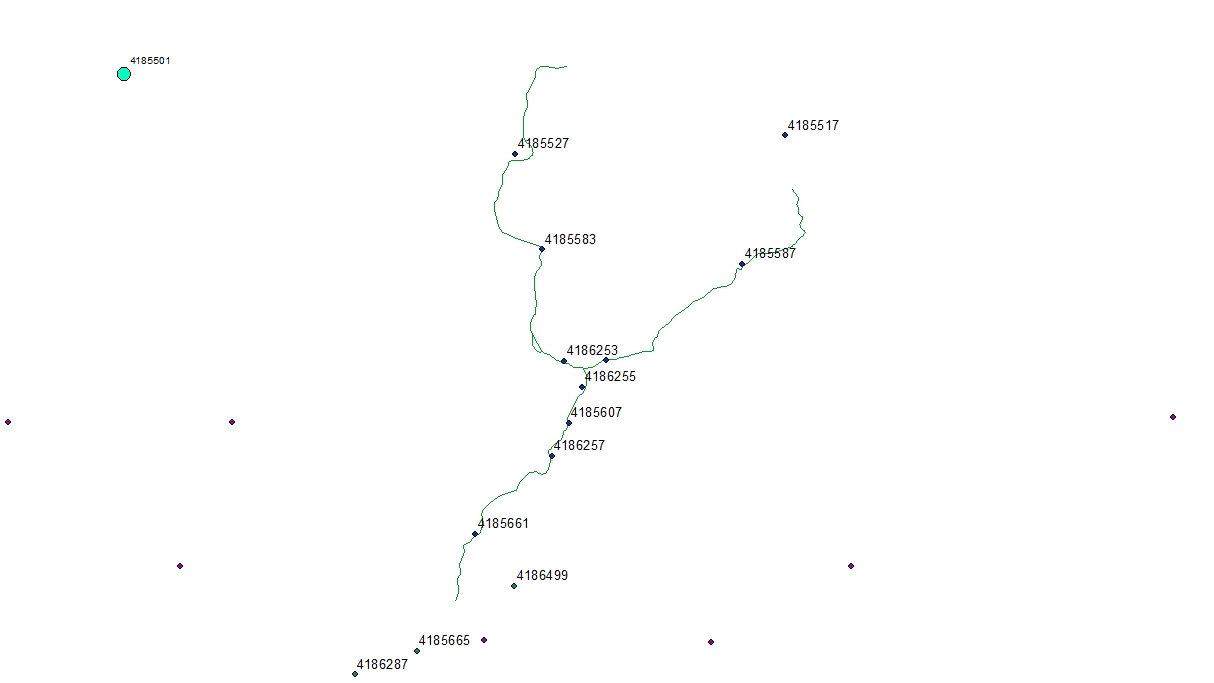

, where each segment has upper and lower nodes and adjacent segments share a common node either at upper or lower end.  Therefore, the number of nodes is always one more that the number of segments at a given reach. To communicate these two configurations without any glitch, the upper left reach, for example, now takes one more segment, called fake semgment, so that the new segmet configuration becomes 4185527, 4185583, 4186253, 41862532.  41862532 is the fake segment which is created by appending 2 to the end of the right upstream segment 41862532.  Now, the new segment configuration becomes equivalent to the node configuration the fortran diffusive model uses.

The head nodes 4185527 and 4185517 take headbasin inflows and the fake segment 41856612 provides water depth boundary condition.  In this demo, these boundary conditions as well as later inflow between adjacent nodes are artificially created based on exponential equations. 



In [ ]:
## Basic imports
import sys
import os
import time

# WARNING: These global declarations cause the parallel implementation to 
# crash when executed on Windows
connections = None
networks = None
#flowdepthvel = None

from sys import platform
if platform == "linux" or platform == "linux2":
    pass
elif platform == "darwin":
    pass
elif platform == "win32":
    print('The parallel version of compute_nhd_routing.py will not execute as currently')
    print('written due to the lack of a fork() capability in the windows OS.')
    print('For parallel execution, please us a *nix OS.')
    print('\nexiting...')
    sys.exit()
    # Some useful references:
    # https://stackoverflow.com/questions/985281/what-is-the-closest-thing-windows-has-to-fork/985525#985525
    # https://stackoverflow.com/questions/8220108/how-do-i-check-the-operating-system-in-python
    # https://stackoverflow.com/questions/6596617/python-multiprocess-diff-between-windows-and-linux
ENV_IS_CL = False
if ENV_IS_CL: root = '/content/t-route/'
elif not ENV_IS_CL: 
    sys.setrecursionlimit(4000)
#     root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    root = os.path.dirname(os.path.dirname(os.path.abspath('')))
    sys.path.append(os.path.join(root, r'src', r'python_framework'))
    sys.path.append(os.path.join(root, r'src', r'python_routing')) #by Dong Ha
    fortran_source_dir = os.path.join(root, r'src', r'fortran_routing', r'diffCNHI_pylink')
    sys.path.append(fortran_source_dir)
    
## F2PY fortran source codes of diffusive routing using Crank-Nicolson Hermite Interpolation 
# mc_f2py= True
# if mc_f2py:
#     try:
#         import subprocess

#         f2py_call = []
#         f2py_call.append(r'f2py3')
#         f2py_call.append(r'-c')
#         f2py_call.append(r'nrtype.f90')
#         f2py_call.append(r'var_module.f90')
#         f2py_call.append(r'subtools.f90')
#         f2py_call.append(r'readXsection.f90')
#         f2py_call.append(r'uniformflowLT.f90')
#         f2py_call.append(r'calculateDT.f90')
#         f2py_call.append(r'ef_q_y_calc.f90')
#         f2py_call.append(r'-m')
#         f2py_call.append(r'dfcnhi')
#         subprocess.run(f2py_call, cwd=r'../fortran_routing/diffCNHI_pylink',
#                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#     except Exception as e:
#         print(e)
## network and reach utilities
import nhd_network_utilities as nnu
import nhd_reach_utilities as nru
# import channel_routing_tools as crt
import numpy as np
import dfcnhi as df
import statistics as stat
#import pixiedust
import set_boundarydata as setbd
import xsec_lookuptable as xseclt
import routelink_adjustment as rladj
import waterdepth_lookuptable as wdlt
import diffusive_routing_tools as dfrt


#%%pixie_debugger
   
def dfcnhi_route_network(
                        terminal_segment = None
                        , network = None
                        , supernetwork_data = None
                        , dtini = None
                        , t0= None
                        , tfin= None
                        , saveinterval= None
                        , cfl= None
                        , dtinput= None
                        , nxsecpt= None
                        , nel= None
                        , timesdepth= None
                        , nhincr_m= None
                        , nhincr_f= None
                        , dbsegID= None
                        , bdrydata= None
                        , verbose = False
                        , debuglevel = 0
                        , output_path= None
                        ):
    
    global connections

    #--------------------------------------------------------------------------------------------------
    #                                        Step 0-1    
    #  Define key dictionary variables
    #--------------------------------------------------------------------------------------------------
    # ** water parameters
    # dtini: initial time interval in sec
    # t0: simulation starting time in hr
    # tfin: simulation ending time in hr
    # saveinterval: output publishing time interval in sec
    ntss= 4.0*(tfin - t0)*3600.0/dtini # the possible number of simulation steps 
    ntss=int(ntss)
    ydaq = {connection:{'elev':np.zeros(ntss)
                        ,'depth':np.zeros(ntss)
                        ,'area':np.zeros(ntss)
                        ,'q':np.zeros(ntss)}
                        for connection in connections}   
    # dtinput: time interval of input data,that is, lateral, q at headsegment, and y at ds boundary [sec]
    ntsi= (tfin - t0)*3600.0/dtinput
    ntsi= int(ntsi)
    tarri=np.zeros(ntsi)
    arri=np.zeros(ntsi)
    for tsi in range (0,ntsi):
        tarri[tsi]=dtinput*float(tsi)/60.0 #[min]
    # ** lateral inflows
    qlatral = {connection:{'qlat':np.zeros(ntsi)
                        } for connection in connections} 
    # ** headbasin discharge
    q_bdseg={connection:{'known discharge':np.zeros(ntsi)
                          } for (connection, cv) in connections.items()
                                                 if cv['upstreams']=={0}}     
    # ** depth at downstream boundary
    dbfksegID= str(dbsegID) + str(2)
    dbfksegID= int(dbfksegID) 
    h_bdseg={dbfksegID:{'known depth':np.zeros(ntsi)}}
    # ** Diffusive model parameters
    dfpara={connection:{'celerity':np.zeros(1)
                        ,'diffusivity':np.zeros(1)
                        ,'qpx':np.zeros(1)}
                        for connection in connections}     
    # ** x-sec attribute lookup table variables    
    # nel: the number of incrementally increasing water depth lines
    xsec_attr_all={connection:{'elev':np.zeros(nel)
                        ,'convey':np.zeros(nel)
                        ,'topwd':np.zeros(nel)
                        ,'uniflow':np.zeros(nel)}
                           for connection in connections} 
    # ** uniform flow discharge-normal depth lookup table variables 
    # nhincr_m: the number of depth increments of main channel
    # nhincr_f: the number of depth increments of floodplain
    uflt={connection:{'q_m':np.zeros(nhincr_m)
                      ,'h_m':np.zeros(nhincr_m)
                      ,'q_f':np.zeros(nhincr_f)
                      ,'h_f':np.zeros(nhincr_f)}
                        for connection in connections} 
    # ** channel attribute adjustment 
    z_all={connection:{'adj.alt':np.zeros(1)}
                        for connection in connections}   
                                      
    # dictionary all keyed by head_segment key
    ordered_reaches = {}
    last_segment_reach={}
    lsegs_usrch={}
    ncompall={}
    fksegID_dsend={}
    seg_list_all={}

    for head_segment, reach in network['reaches'].items():
        if reach['seqorder'] not in ordered_reaches:
            ordered_reaches.update({reach['seqorder']:[]}) 
        # Ordered_reaches contains network dictionary values according to seqorder (= 
        # the number of juctions downstream).
        ordered_reaches[reach['seqorder']].append([head_segment, reach])
        last_segment_reach[head_segment]= reach['reach_tail']                  

    # Count the total number of segments for each reach in computation
    # ** Note that routing models use node configuration where one segment has
    # ** has upper and lower nodes and each segment shares common nodes at either 
    # ** direction. So, the number of nodes of a given reaach becomes equiv. to
    # ** the number of segments + 1.
    tnseg=0
    nrch=0 # the number of reaches
    for x in range(network['maximum_reach_seqorder'],-1,-1):  
        for head_segment, reach in ordered_reaches[x]:                        
            seg_list0=list(reach['segments_list'])
            seg_list=seg_list0[::-1] #to reversed order
            # check if there is a downstream boundary segment in the given reach.
            if seg_list0.count(dbsegID)>0:
                # identify where dsbdID is located along the given reach, and count 
                # segments upward from and including the dsbdID segment.                    
                idx= seg_list0.index(dbsegID)
                tnseg= tnseg+len(seg_list)-idx
                ncomp= len(seg_list)-idx+1 
            else:
                #the number of segments of a given reach 
                tnseg= tnseg+ len(seg_list)
                ncomp= len(seg_list)+1
            ncompall.update({head_segment:ncomp})                   
            nrch= nrch +1 # counts the number of reaches 

    #---------------------------------------------------------------------------------------
    #                            Step 0-2    

    #  Update key dictionary variables
    #---------------------------------------------------------------------------------------
    # Add one more fake segment after downstream terminal segment in a reach
    # by "terminal segmentID"+"2". This is to account for one more node in
    # Fortran node configuration, which is equivalent to Python segment 
    # configuration.
            fksegID= seg_list[ncomp-2]
            fksegID= str(fksegID) + str(2)
            fksegID=int(fksegID)
            fksegID_dsend.update({head_segment:fksegID})                     

            ydaq.update({fksegID:{'elev':np.zeros(ntss)
                                ,'depth':np.zeros(ntss)
                                ,'area':np.zeros(ntss)
                                ,'q':np.zeros(ntss)}})

            xsec_attr_all.update({fksegID:{'elev':np.zeros(nel)
                                        ,'convey':np.zeros(nel)
                                        ,'topwd':np.zeros(nel)
                                        ,'uniflow':np.zeros(nel)}})

            uflt.update({fksegID:{'q_m':np.zeros(nhincr_m)
                                  ,'h_m':np.zeros(nhincr_m)
                                  ,'q_f':np.zeros(nhincr_f)
                                  ,'h_f':np.zeros(nhincr_f)}})

            qlatral.update({fksegID:{'qlat':np.zeros(ntsi)}})

            dfpara.update({fksegID:{'celerity':np.zeros(1)
                                        ,'diffusivity':np.zeros(1)
                                        ,'qpx':np.zeros(1)}})

            seg_list.append(fksegID_dsend[head_segment])

            seg_list_all.update({head_segment:seg_list})

            z_all.update({fksegID:{'adj.alt':np.zeros(1)}}) 

    cel_av=np.zeros(nrch) # holds reach-averaged celerities

    #--------------------------------------------------------------------------------------
    #                                 Step 0-3           

    #    Adjust altitude so that altitude of the last sement of a reach is equal to that 
    #    of the first segment of its downstream reach right after their common junction.
    #--------------------------------------------------------------------------------------
    rladj.adj_alt1(        
                connections= connections 
                , supernetwork_data= supernetwork_data 
                , network= network
                , ordered_reaches= ordered_reaches
                , seg_list_all= seg_list_all
                , ncompall= ncompall 
                , dbfksegID= dbfksegID
                , z_all= z_all
                )   

    #---------------------------------------------------------------------------------------
    #                                 Step 0-4

    #  Make channel x-sec attribute lookup tables for each node (p.132,rm4)
    #  ** tzeq_flag= 0: use an approximation method based on finite rectangles or triangle 
    #                       for any regular or irregular x-sec
    #                1: use related equations only for trapezoidal main & rectangular 
    #                        floodplains
    #  ** Output: 
    #            xsec_attr_all
    #              ** this variable also stores uniform flow values corresponding to elev.
    #----------------------------------------------------------------------------------------
    xseclt.xsecTR_ltable(        
                        connections= connections
                        , supernetwork_data= supernetwork_data
                        , network= network
                        , ordered_reaches= ordered_reaches
                        , seg_list_all= seg_list_all
                        , ncompall= ncompall
                        , z_all= z_all
                        , nxsecpt= nxsecpt
                        , nel= nel
                        , timesdepth= timesdepth
                        , tzeq_flag= 0
                        , xsec_attr_all= xsec_attr_all
                        )
    #---------------------------------------------------------------------------------
    #                              Step 0-5

    #  Create uniform flow-normal depth lookup tables using channel geometry equations
    #  ONLY for trapezoidal main and rectangular floodplains (p.132,rm4)            
    #---------------------------------------------------------------------------------
    wdlt.ufTR_ltable(        
                    connections= connections 
                    , supernetwork_data= supernetwork_data
                    , network= network
                    , ordered_reaches= ordered_reaches
                    , seg_list_all= seg_list_all
                    , ncompall= ncompall
                    , nhincr_m= nhincr_m
                    , nhincr_f= nhincr_f
                    , uflt= uflt
                    )   

    #-----------------------------------------------------------------------------------------
    #                                       Step 1

    # Set boundary data such as discharge, water depth, lateral flow by either data import or 
    # artificial equations.       
    # ** the unit of qlat that is eventually used in the routing SHOULD BE [m^2/sec].
    # ** qlat of fake segment of the last segment of a reach is always ZERO.
    #-----------------------------------------------------------------------------------------            
    setbd.set_bdrydata(        
                    connections= connections  
                    , supernetwork_data= supernetwork_data
                    , network= network
                    , ordered_reaches= ordered_reaches
                    , seg_list_all= seg_list_all
                    , ncompall= ncompall 
                    , fksegID_dsend= fksegID_dsend
                    , dbfksegID= dbfksegID
                    , ntsi= ntsi
                    , bdrydata= bdrydata
                    , q_bdseg= q_bdseg
                    , h_bdseg= h_bdseg
                    , qlatral= qlatral
                    )   

    #------------------------------------------------------------------------------------
    #                                   Step 2

    #    Intial condition of q (p.130,rm4)
    #------------------------------------------------------------------------------------
    dfrt.icond_q(          
                connections= connections
                , supernetwork_data= supernetwork_data
                , network= network
                , ordered_reaches= ordered_reaches
                , fksegID_dsend= fksegID_dsend
                , seg_list_all= seg_list_all
                , ncompall= ncompall
                , z_all= z_all
                , q_bdseg= q_bdseg
                , ydaq= ydaq
                , qlatral= qlatral
                ) 
    #-------------------------------------------------------------------------------------
    #                                     Step 3

    #       Run diffusive routing based on Crank-Nicholson & Hermite Interpolation
    #         
    #-------------------------------------------------------------------------------------    
    df.var.t0=t0              # simulation starting time in hr
    df.var.tfin=tfin          # simulation ending time in hr
    df.var.saveinterval= saveinterval # output publish time interval in sec
    df.var.cfl= cfl          # max. allowable Courant number           
    dx_mn=min([connections[segID]['data'][supernetwork_data['length_col']] for segID in connections]) 
    df.var.dx_mn=dx_mn         # minimum length value among all segments of a network
    cel_mx= 1.0        # initial max.celerity 
    tc=t0*60.0 # simulation time interval [min]
    ts=0  # counts the occurence of tc
    theta=1.0

    while tc < tfin*60.0: 
        #----------------------------------------------------------------------------------------
        #                                   Step 3-1

        #           compute dtini for an acceptable diffusion,p133,rm4
        #----------------------------------------------------------------------------------------    
        df.var.tc=tc

        # note: cel_mx needs to be updated
        df.var.cel_mx= cel_mx 

        df.simtime.cal_dt() # output-> dtini [sec]

        dtini=df.var.dtini
        #----------------------------------------------------------------------------------------
        #                                   Step 3-2

        #    As moving reach by reach from upstream to downstream, compute the following 
        # for each reach:           

        #  1) E,F,Ex,Fx from upper end node to lower end node of a given reach, p146,rm4.
        #  2) q and qpx at ts+1 from lower end node to upper end node of a given reach.  
        #----------------------------------------------------------------------------------------  
        dfrt.dfcnhi_qqpx(          
                        connections= connections
                        , supernetwork_data= supernetwork_data
                        , network= network
                        , ordered_reaches= ordered_reaches
                        , fksegID_dsend= fksegID_dsend
                        , seg_list_all= seg_list_all
                        , ncompall= ncompall
                        , ntsi= ntsi
                        , dtini = dtini
                        , tc= tc
                        , ts= ts
                        , saveinterval= saveinterval
                        , theta= theta
                        , tarri= tarri
                        , q_bdseg= q_bdseg
                        , ydaq= ydaq
                        , dfpara= dfpara
                        , qlatral= qlatral
                        , output_path= output_path
                        )

        #----------------------------------------------------------------------------------------
        #                                   Step 3-3

        #    As moving reach by reach from downstream to upstream, compute the following 
        # for each reach:           

        #  1) y, celerity, diffusivity at ts+1 from lower end node to upper end node of 
        #  a given reach, p149,rm4.
        #----------------------------------------------------------------------------------------  
        dfrt.dfcnhi_elv(          
                    connections= connections
                    , supernetwork_data= supernetwork_data
                    , network= network
                    , ordered_reaches= ordered_reaches
                    , seg_list_all= seg_list_all
                    , ncompall= ncompall
                    , z_all= z_all
                    , ntsi= ntsi
                    , dtini = dtini
                    , tc= tc
                    , ts= ts
                    , saveinterval= saveinterval
                    , tarri= tarri 
                    , tzeq_flag= 0
                    , y_opt= 1
                    , dbfksegID= dbfksegID
                    , h_bdseg= h_bdseg
                    , nel= nel
                    , xsec_attr_all= xsec_attr_all
                    , nhincr_m= nhincr_m
                    , nhincr_f= nhincr_f
                    , uflt= uflt                      
                    , ydaq= ydaq
                    , dfpara= dfpara
                    , cel_av= cel_av
                    , output_path= output_path
                    )  

        tc= tc + dtini/60.0 # [min]
        ts= ts+1
        cel_mx=max(cel_av) 



    #while tc < tfin*60.0:     

#%%pixie_debugger
#if 1==1:
def main():

    global connections
    global networks
    #global flowdepthvel
    global ydaq
    global dfpara
                      
    verbose = True
    debuglevel = 0
    showtiming = True

    test_folder = os.path.join(root, r'test')
    geo_input_folder = os.path.join(test_folder, r'input', r'geo', r'Channels')
    output_path='./output2'
    
    #TODO: Make these commandline args
    supernetwork= 'Pocono_TEST3_3R1J'
    """##NHD Subset (Brazos/Lower Colorado)"""
#     supernetwork = 'Brazos_LowerColorado_ge5'
    """##NHD CONUS order 5 and greater"""
    # supernetwork = 'CONUS_ge5'
    """These are large -- be careful"""                          
#     supernetwork = 'Mainstems_CONUS'
    # supernetwork = 'CONUS_FULL_RES_v20'
    # supernetwork = 'CONUS_Named_Streams' #create a subset of the full resolution by reading the GNIS field
    # supernetwork = 'CONUS_Named_combined' #process the Named streams through the Full-Res paths to join the many hanging reaches

    if verbose: print('creating supernetwork connections set')
    if showtiming: start_time = time.time()
    #STEP 1
    supernetwork_data, supernetwork_values = nnu.set_networks(
        supernetwork = supernetwork
        , geo_input_folder = geo_input_folder
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        )
    if verbose: print('supernetwork connections set complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

    #STEP 2
    if showtiming: start_time = time.time()
    if verbose: print('organizing connections into networks and reaches ...')
    networks = nru.compose_reaches(
        supernetwork_values
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        , showtiming = showtiming
        )
    if verbose: print('reach organization complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))
    

    #STEP 3: Route NHD streamflow
    if showtiming: start_time = time.time()
    executiontype = 'serial' # 'parallel'

    if verbose: print('executing serial computation on ordered reaches ...')
    connections = supernetwork_values[0]
    
    #----------------------------------------------------------
    # diffusive CNHI model time variables
    
    #----------------------------------------------------------    
    dtini= 10.0 # initial time interval in sec
    t0= 0.0     #simulation starting time in hr
    tfin=5.0   # simulation ending time in hr
    saveinterval=300 #output publishing time interval in sec
    cfl= 0.8           # max. allowable Courant number 
    dtinput= 300.0 # time interval of input data,that is, lateral, q at headsegment, and y at ds boundary [sec]
    #----------------------------------------------------------
    # x-sec attribute lookup table variables
    
    #----------------------------------------------------------    
    nxsecpt=8 #the number of (x,y) points for x-sec geometry
    nel=201 # the number of incrementally increasing water depth lines
    timesdepth=5.0  # multiplier to bankfull depth to cover potentially largest water depth

    #-------------------------------------------------------------
    #  uniform flow discharge-normal depth lookup table variables
    
    #-------------------------------------------------------------     
    nhincr_m=50  # the number of depth increments of main channel
    nhincr_f=100 # the number of depth increments of floodplain
    
    #-------------------------------------------------------------
    #  downstream boundary parameters
    
    #-------------------------------------------------------------     
    dbsegID= 4185661  # downstream boundary segment ID
                  
    if executiontype == 'serial':
        iter=0
        for terminal_segment, network in networks.items():
            if showtiming: network_start_time = time.time()
            iter=iter+1
            print(f"terminal_segment iter-> {iter}")
            
            toseg=connections[terminal_segment]['data'][supernetwork_data['downstream_col']]
            if toseg != 0:
            ## run diffusive routing based on CNHI to route network 
                dfcnhi_route_network(
                                      terminal_segment = terminal_segment
                                    , network = network
                                    , supernetwork_data = supernetwork_data
                                    , dtini = dtini
                                    , t0= t0
                                    , tfin= tfin
                                    , saveinterval= saveinterval
                                    , cfl= cfl
                                    , dtinput= dtinput
                                    , nxsecpt= nxsecpt
                                    , nel= nel
                                    , timesdepth= timesdepth
                                    , nhincr_m= nhincr_m
                                    , nhincr_f= nhincr_f
                                    , dbsegID= dbsegID
                                    , bdrydata= "artf_data1"
                                    , verbose = False
                                    , debuglevel = 0
                                    , output_path= output_path
                                    )

                if verbose: print(f'{terminal_segment} completed')
                if showtiming: print("... in %s seconds." % (time.time() - network_start_time))

    if verbose: print('ordered reach computation complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

if __name__ == '__main__':
    main()
